# Apple Recognition

In [2]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt 

In [42]:
IMAGE_SIZE=256
BATCH_SIZE=32
CHANNELS=3
EPOCHS=30

In [8]:
dataset=tf.keras.preprocessing.image_dataset_from_directory(
    "train",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 449 files belonging to 2 classes.


In [10]:
class_names=dataset.class_names
class_names

['freshapples', 'rottenapples']

In [12]:
for image_batch , labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[1 1 1 1 1 0 0 0 1 1 1 1 1 1 1 0 0 1 0 1 1 1 0 1 0 0 1 0 0 0 1 1]


In [13]:
for image_batch , labels_batch in dataset.take(1):
    print(image_batch.numpy())

[[[[255.       255.       255.      ]
   [255.       255.       255.      ]
   [255.       255.       255.      ]
   ...
   [255.       255.       255.      ]
   [255.       255.       255.      ]
   [255.       255.       255.      ]]

  [[255.       255.       255.      ]
   [255.       255.       255.      ]
   [255.       255.       255.      ]
   ...
   [255.       255.       255.      ]
   [255.       255.       255.      ]
   [255.       255.       255.      ]]

  [[255.       255.       255.      ]
   [255.       255.       255.      ]
   [255.       255.       255.      ]
   ...
   [255.       255.       255.      ]
   [255.       255.       255.      ]
   [255.       255.       255.      ]]

  ...

  [[255.       255.       255.      ]
   [255.       255.       255.      ]
   [255.       255.       255.      ]
   ...
   [255.       255.       255.      ]
   [255.       255.       255.      ]
   [255.       255.       255.      ]]

  [[255.       255.       255.      ]
   [255

In [14]:
#visualize

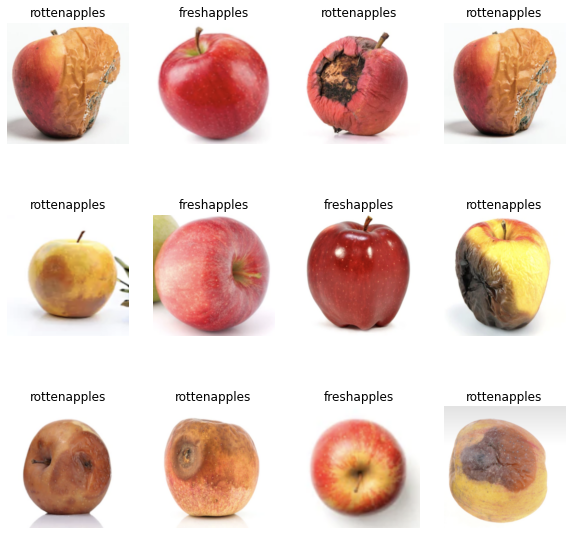

In [16]:
plt.figure(figsize=(10,10))
for image_batch , labels_batch in dataset.take(1):
    for i in range(12):
        ax=plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [18]:
def get_dataset(ds,train_split=0.8,val_split=0.1,test_split=0.1,shuffle=True,shuffle_size=10000):
    assert(train_split+test_split+val_split)==1
    
    ds_size=len(ds)
    if shuffle:
        ds=ds.shuffle(shuffle_size,seed=12)
    
    train_size=int(train_split*ds_size)
    val_size=int(val_split*ds_size)
    
    train_ds=ds.take(train_size)
    val_ds=ds.skip(train_size).take(val_size)
    test_ds=ds.skip(train_size).skip(val_size)
    
    return train_ds,val_ds,test_ds

In [20]:
train_ds,val_ds,test_ds=get_dataset(dataset)

In [22]:
len(train_ds),len(val_ds),len(test_ds)

(12, 1, 2)

In [23]:
#shuffle

In [25]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [26]:
#building the build

In [28]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [29]:
#data augmentation 

In [31]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [32]:
# apply augmentation to training data 

In [35]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [36]:
# model architecture 

In [38]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 6

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [39]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d_6 (Conv2D)           (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_6 (MaxPoolin  (32, 127, 127, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (32, 60, 60, 64)         

In [41]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [43]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=30,
)

Epoch 1/30
12/12 [==============================] - 20s 1s/step - loss: 1.2689 - accuracy: 0.4164 - val_loss: 0.7341 - val_accuracy: 0.3750
Epoch 2/30
12/12 [==============================] - 17s 1s/step - loss: 0.7417 - accuracy: 0.5637 - val_loss: 0.6960 - val_accuracy: 0.5938
Epoch 3/30
12/12 [==============================] - 17s 1s/step - loss: 0.7057 - accuracy: 0.5467 - val_loss: 0.7675 - val_accuracy: 0.4062
Epoch 4/30
12/12 [==============================] - 16s 1s/step - loss: 0.7131 - accuracy: 0.5269 - val_loss: 0.6924 - val_accuracy: 0.5938
Epoch 5/30
12/12 [==============================] - 16s 1s/step - loss: 0.7070 - accuracy: 0.5921 - val_loss: 0.7167 - val_accuracy: 0.4375
Epoch 6/30
12/12 [==============================] - 16s 1s/step - loss: 0.7072 - accuracy: 0.4533 - val_loss: 0.6738 - val_accuracy: 0.6250
Epoch 7/30
12/12 [==============================] - 16s 1s/step - loss: 0.6824 - accuracy: 0.6062 - val_loss: 0.8149 - val_accuracy: 0.4062
Epoch 8/30
12/12 [==

In [44]:
scores = model.evaluate(test_ds)

2/2 [==============================] - 2s 324ms/step - loss: 0.1281 - accuracy: 0.9375


In [45]:
scores


[0.12813332676887512, 0.9375]

In [46]:
history

In [47]:
history.params

{'verbose': 1, 'epochs': 30, 'steps': 12}

In [48]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [49]:
type(history.history['loss'])

list

In [50]:
len(history.history['loss'])

30

In [51]:
history.history['loss'][:5] # show loss for first 5 epochs

[1.2688511610031128,
 0.7417376637458801,
 0.7056949734687805,
 0.7130600214004517,
 0.7069883942604065]

In [52]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

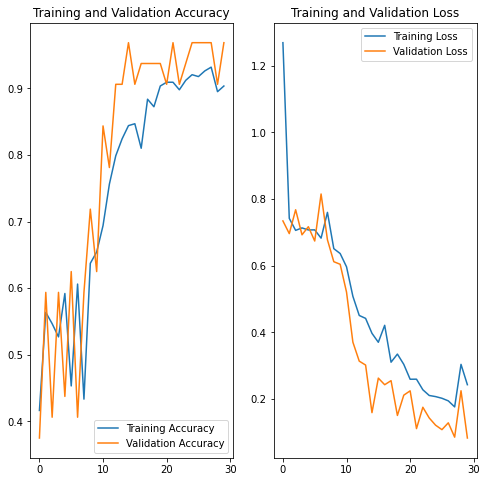

In [53]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [54]:
# Run Prediction on Sample image 

first image to predict
actual label: rottenapples
1/1 [==============================] - 1s 629ms/step
predicted label: rottenapples


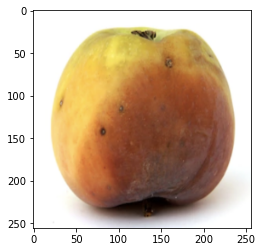

In [55]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])


In [56]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 29ms/step


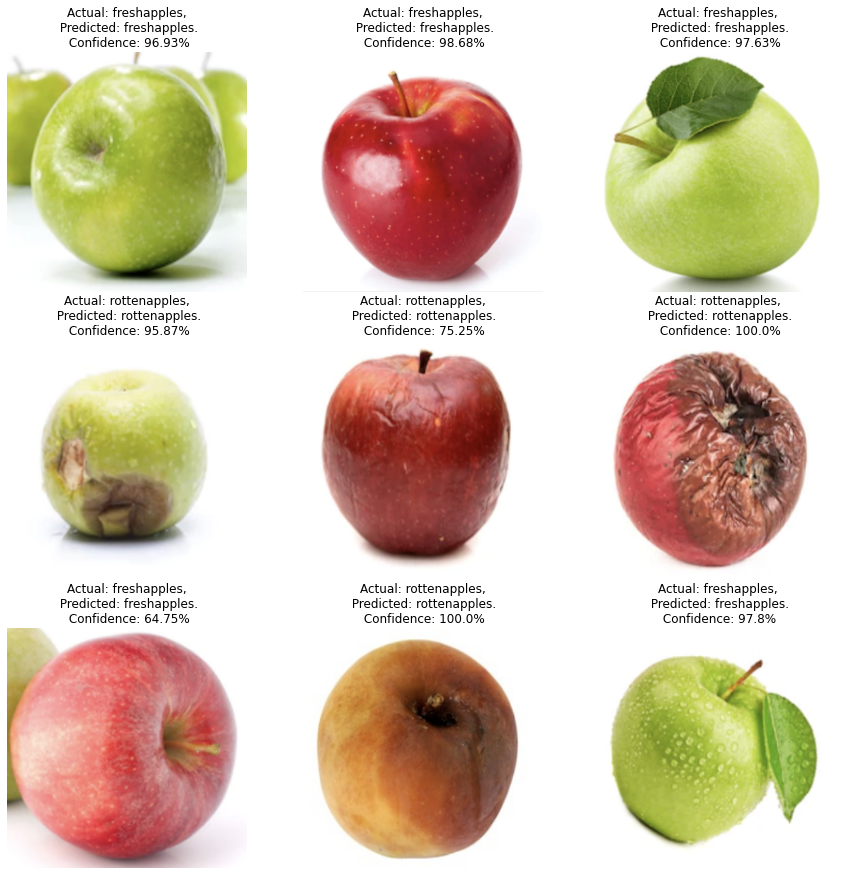

In [58]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [59]:
import os
model_version=max([int(i) for i in os.listdir("models") + [0]])+1
model.save(f"models/{model_version}")

INFO:tensorflow:Assets written to: models/1/assets


INFO:tensorflow:Assets written to: models/1/assets


In [60]:
model.save("models/fruits.h5")

/home/tanuj/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
